In [1]:
import sys, os
sys.path.append("../")

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import matplotlib.gridspec as gridspec
plt.rcParams["font.family"] = "Optima"
plt.rcParams["font.weight"] = "light"

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import arviz as az

import yaml
import json

from epimodel.plotting.intervention_plots import combine_npi_samples

from tqdm import tqdm
import pandas as pd

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Set Theano Environmental Variables for Parallelisation


In [2]:
base_dir_wearing = "../sensitivity_analysis/24_double/"
base_dir_mandates = "../sensitivity_analysis/RW_14_05/mandates/"

In [3]:
exp_main_tags = {
    "Unrecorded factors": ['npi_leaveout', 'mobility_leaveout', 'mob_and_wearing_only', 'fake_wearing_npi'],
    "Data": ["boostrap", 'mask_leave_on', 'mask_thresholds', 'window_of_analysis'],
    "Delay distributions": ["gen_int_mean", "cases_delay_mean", "cases_delay_disp_mean"],
    "Prior distributions": ["basic_R_prior_mean", "basic_R_prior_scale", 'basic_R_hyperprior_mean_mean',
                            'basic_R_hyperprior_mean_scale', "r_walk_noise_scale_prior",
                            "intervention_prior", 'mobility_sigma', 'mobility_mean', 'mask_sigma',
                            'wearing_prior_scale'],
    "Model structure": ["r_walk_period", 'wearing_parameterisation']
}

def get_all_exp_info(base_dir, all_info_dicts=None):

    if all_info_dicts is None:
        all_info_dicts = []
    for subdir, dirs, files in os.walk(base_dir):
        for f in files:
            if f.endswith('.json'):
                with open(os.path.join(subdir, f), 'r') as f:
                    try:
                        info_dict = json.load(f)

                        if 'MandateReduction' in info_dict.keys():
                            npi_name = 'Mask Mandates'
                            reduction = np.array(info_dict['MandateReduction'])
                        else:
                            npi_name = 'Mask Wearing'
                            reduction = np.array(info_dict['WearingReduction'])

                        med = np.median(100*(1-reduction), axis=0)

                        main_tag = None
                        for name, v in exp_main_tags.items():
                            if info_dict["exp_tag"] in v:
                                main_tag = name

                                reduced_info_dict = {
                                    'npi': npi_name,
                                    "med": med,
                                    'tag': main_tag
                                }
                                all_info_dicts.append(reduced_info_dict)
                                # print(len(all_info_dicts))
                            # else:
                            #     print(f'{info_dict["exp_tag"]} not in dict')

                    except Exception as e:
                        print(e)

    return all_info_dicts

In [4]:
all_wearing_dicts = get_all_exp_info(base_dir_wearing)

Expecting ',' delimiter: line 17280160 column 35 (char 593248761)


In [5]:
meds = pd.DataFrame(all_wearing_dicts)['med']
print(f'Mean: {np.mean(meds)}, sd: {np.sqrt(np.var(meds))}')

Mean: [28.77076487], sd: 3.7276122016852344


In [6]:
all_dicts = get_all_exp_info(base_dir_mandates, all_wearing_dicts)

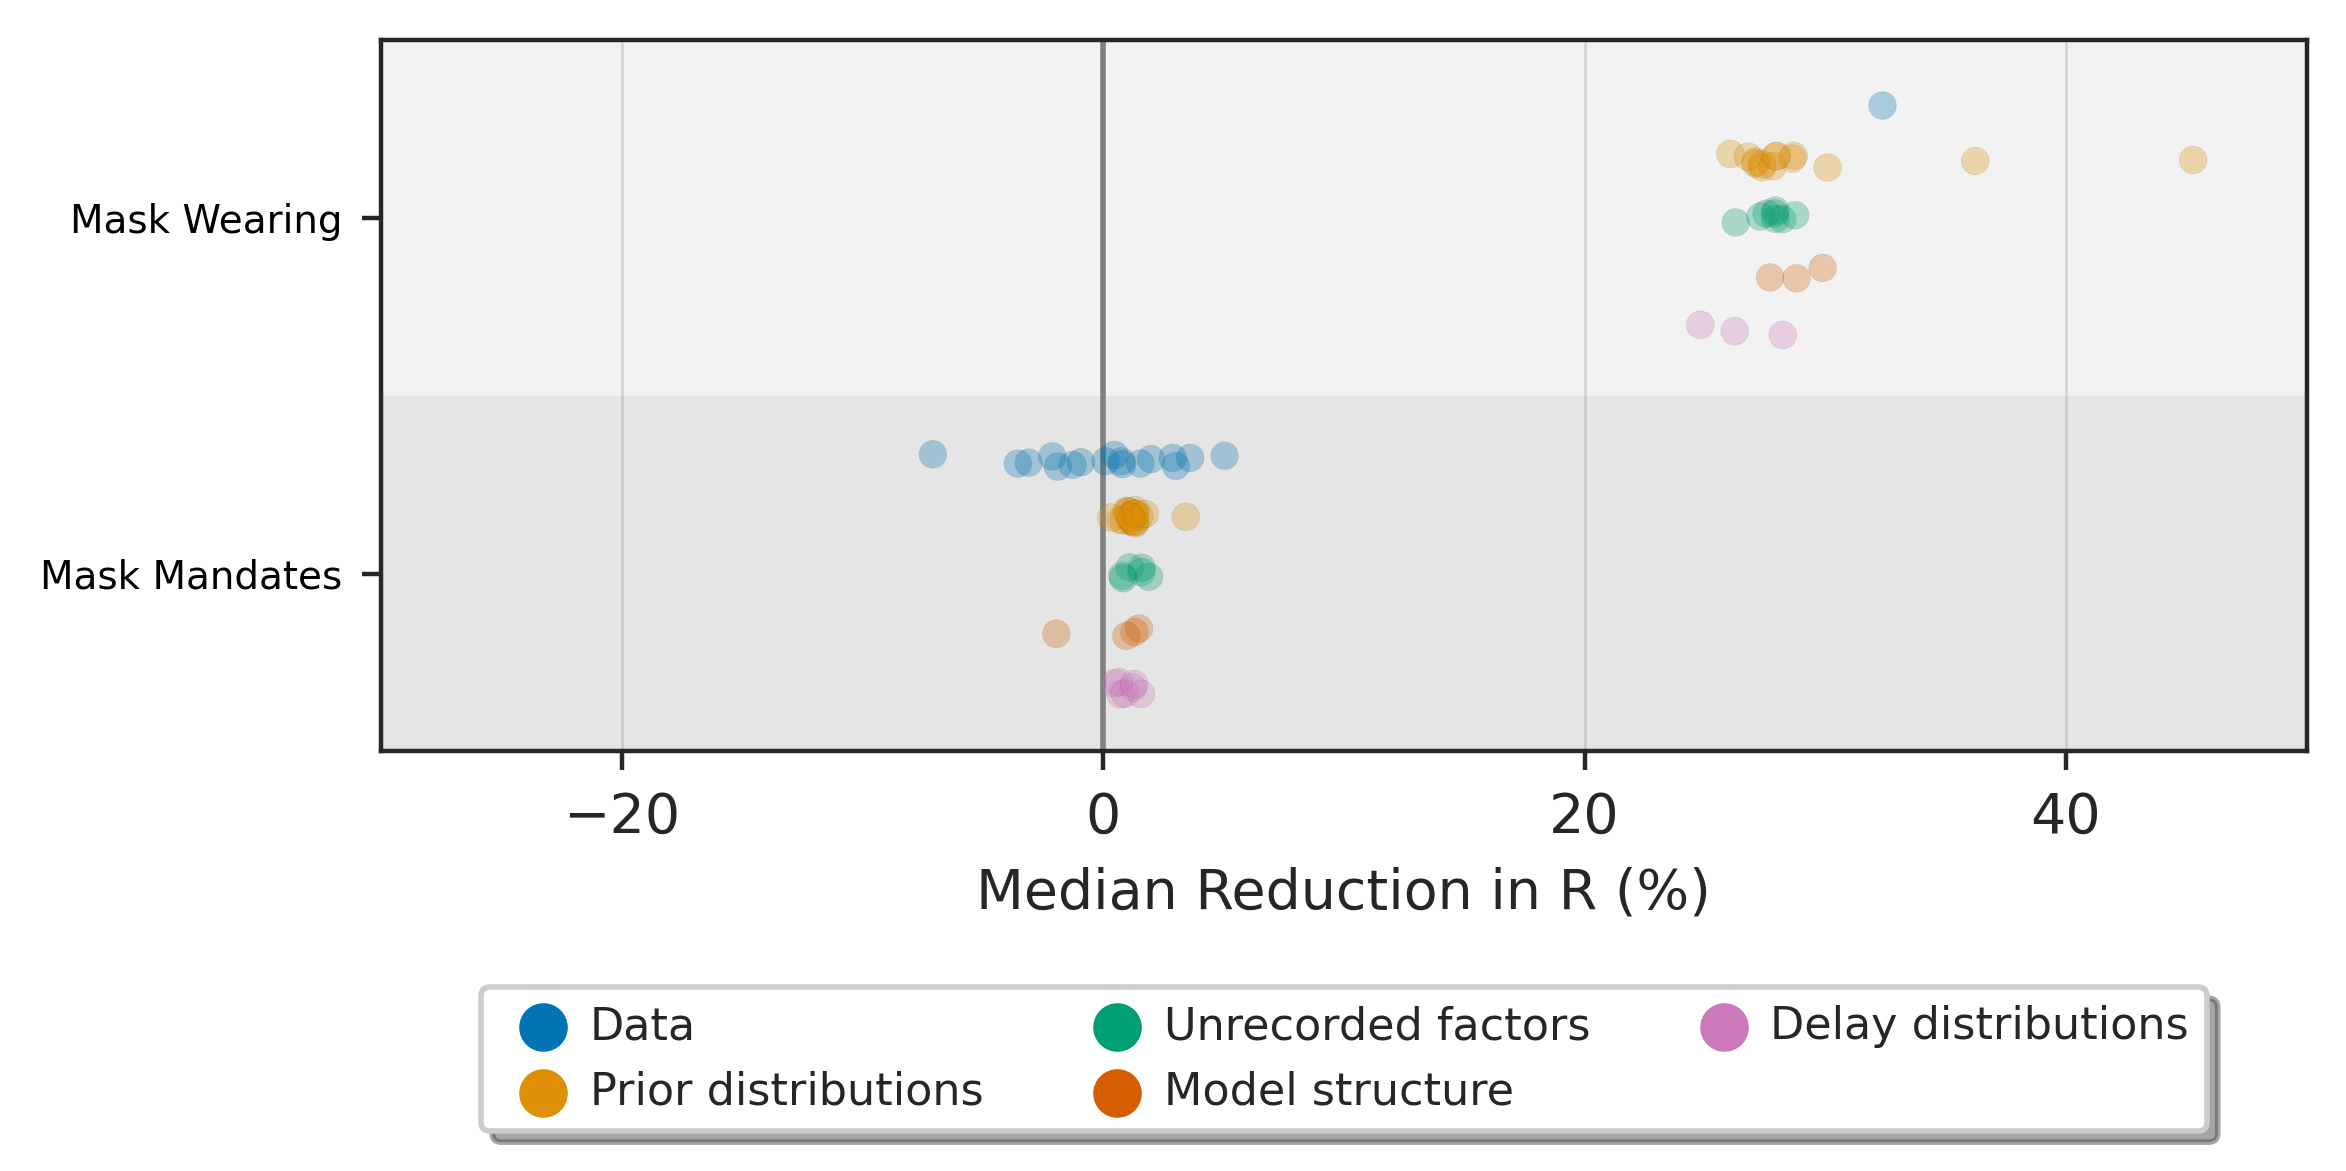

In [7]:
sns.color_palette('colorblind')
cols = sns.color_palette('colorblind')

main_dict = {
    'Mask Wearing' : {
        'npis': ['Mask Wearing'],
        'type': 'include',
        'color': 'black',
        'main': True,
    },
        'Mask Mandates': {
        'npis': ['Mask Mandates'],
        'type': 'include',
        'color': 'black',
        'main': True,
    }
}

npi_medians_df = pd.DataFrame(all_dicts)

fig = plt.figure(constrained_layout=True, figsize=(5.75, 3.75), dpi=400)
gs = gridspec.GridSpec(ncols=8, nrows=11, figure=fig)

main_ax = fig.add_subplot(gs[:8, :])

exp_tags = np.unique(npi_medians_df["tag"])
cols = [*sns.color_palette('colorblind'), *sns.color_palette('bright')]
plt.plot([0, 0], [-1, 40], linestyle='-', alpha=1, zorder=-5, linewidth=1, color="tab:gray")


npi_names = list(main_dict.keys())
npi_cols = [d['color'] for k, d in main_dict.items()] #maybe this should be something else

for i, col in enumerate(npi_cols):
    if i % 2 == 0:
        plt.fill_between(
            [-100, 100],
            [i-0.5, i-0.5],
            [i+0.5, i+0.5],
            color=col,
            alpha=0.05,
            linewidth=0,
            zorder=-5
        )
    else:
         plt.fill_between(
            [-100, 100],
            [i-0.5, i-0.5],
            [i+0.5, i+0.5],
            color=col,
            alpha=0.1,
            linewidth=0,
            zorder=-5
        )

sns.stripplot(x="med", y="npi", data=npi_medians_df, size=5, zorder=1,
          jitter=0.1, order=npi_names, alpha=0.3, hue="tag", dodge=True,
          palette="colorblind", linewidth=0.05)

for i, tick in enumerate(plt.gca().get_yticklabels()):
    tick.set_color(npi_cols[i])

plt.yticks(fontsize=7, linespacing=0.8)
plt.xlabel("Median Reduction in R (%)")
plt.ylabel("")
plt.xlim([-30, 50])
plt.grid(axis='x', linewidth=0.5, zorder=-10, color="tab:gray", alpha=0.25)
plt.xticks([-20, 0, 20, 40])
plt.yticks()
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', fontsize=8, ncol=3, fancybox=True, shadow=True, handletextpad=0.05)
plt.savefig('validation_all.pdf', bbox_inches='tight')
